In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers

from keras.models import Model, Sequential
from keras import layers

import tensorflow as tf
print(tf.__version__)

# check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

2.10.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<br><br><br>

## Dataset Preparation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore
 
# your directories
train_dir="animal_dataset/train"
valid_dir="animal_dataset/valid"

# if you want to augmented dat set use it like this : prep_data(True)
def prep_data(augmented,batch_size=16):      
    if augmented:          
        # you can change this parameters                   
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
        
        # Augmentation is applied only to the training set
        validation_datagen = ImageDataGenerator(rescale=1./255)    
 
    else:
        # if you set augmented=False , images are just rescaled
        train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
 
    # training set
    train_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(180, 180),  # The dimensions to which all images found will be resized
        batch_size=batch_size, 
        class_mode="sparse") # you can change this to onehotEncoded format or another format  
          
     
    # validation set
    validation_set = validation_datagen.flow_from_directory(
        valid_dir,
        target_size=(180, 180),
        batch_size=batch_size, 
        class_mode="sparse")
              
    return train_set , validation_set


# create dataset (augmented or not augmented , it is up to you , process is same in both cases
train_set,validation_set=prep_data(True)

Found 3780 images belonging to 90 classes.
Found 1620 images belonging to 90 classes.


<br><br>

## Display Example Images from dataset

Found 3780 images belonging to 90 classes.
Found 1620 images belonging to 90 classes.


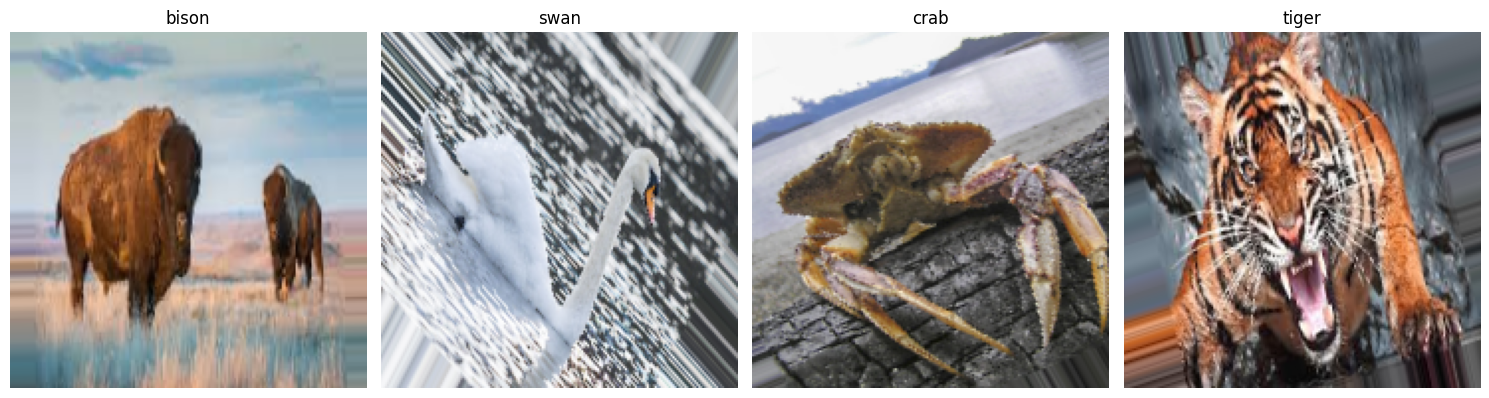

In [6]:
import matplotlib.pyplot as plt 
 
# create dataset (augmented or not augmented , it is up to you , process is same in both cases
train_set,validation_set=prep_data(True)
 
images,labels=train_set.next()
 
class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()}
 
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
 
for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')
 
plt.tight_layout()
plt.show()

<br><br><br>

## Class Distribution

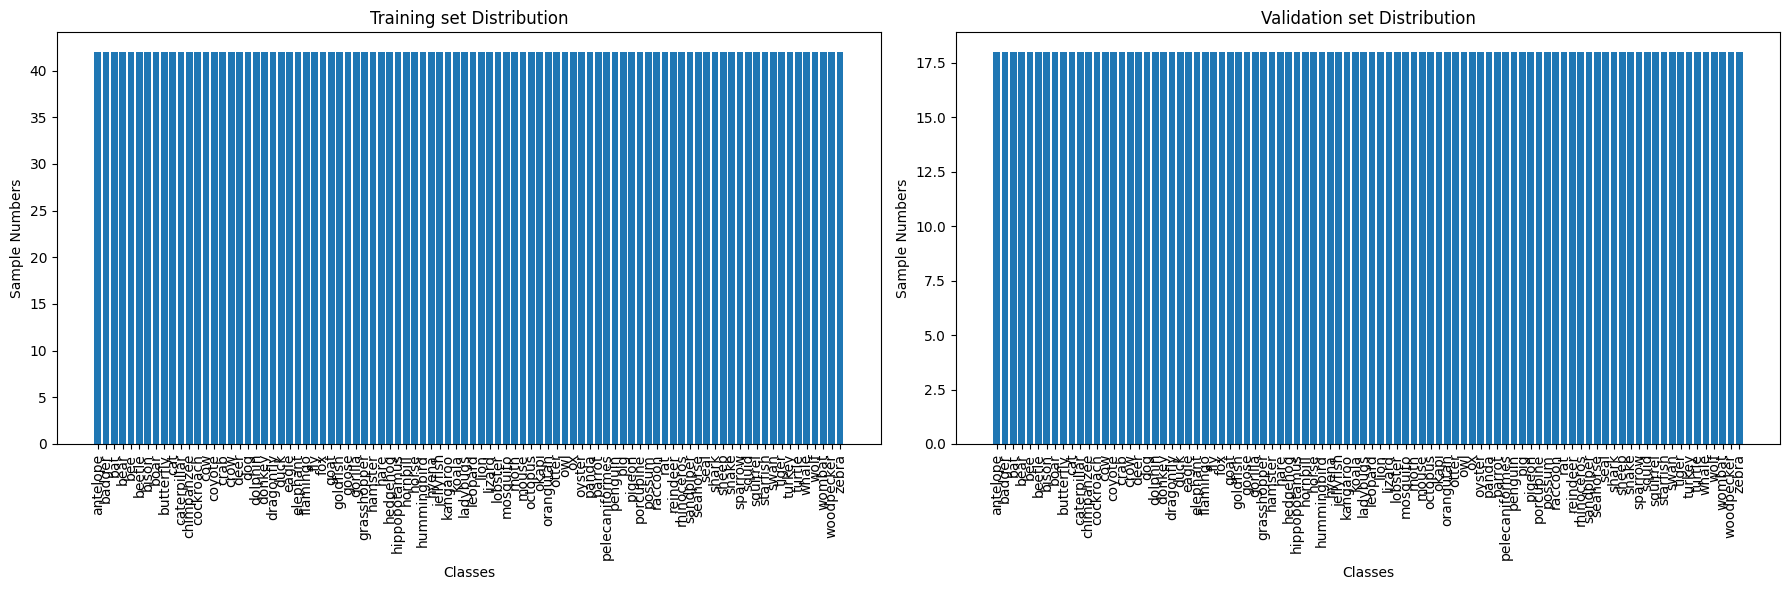

In [7]:
import os
import matplotlib.pyplot as plt
 
# calculate distribution in training set
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images
 
# calculate distribution in validation set
validation_class_counts = {}
for class_folder in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images
 
 
plt.figure(figsize=(18, 6))
 
# training
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=90)
 
# validation
plt.subplot(1, 2, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Validation set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=90)
 
plt.tight_layout()
plt.show()

<br><br>

## Load backbone

In [ ]:
from tensorflow.keras.applications import InceptionV3 

# Define the base model, InceptionV3 as backbone. Don't include the top layers.
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [46]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Create the model
model = Sequential()

# Add the base model
model.add(base_model)

# Add custom layers on top
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # 
model.add(layers.Dropout(0.2))   

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.15))    
model.add(layers.Dense(90, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 90)               

In [24]:
fine_tune_inception = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,
    )

Epoch 1/40
237/237 [==============================] - 69s 267ms/step - loss: 4.2703 - accuracy: 0.0701 - val_loss: 3.2672 - val_accuracy: 0.3815
Epoch 2/40
237/237 [==============================] - 60s 252ms/step - loss: 3.1974 - accuracy: 0.2929 - val_loss: 1.8177 - val_accuracy: 0.6488
Epoch 3/40
237/237 [==============================] - 52s 222ms/step - loss: 2.4579 - accuracy: 0.4304 - val_loss: 1.2468 - val_accuracy: 0.7414
Epoch 4/40
237/237 [==============================] - 53s 225ms/step - loss: 2.0064 - accuracy: 0.5254 - val_loss: 1.0040 - val_accuracy: 0.7543
Epoch 5/40
237/237 [==============================] - 54s 226ms/step - loss: 1.7498 - accuracy: 0.5696 - val_loss: 0.8528 - val_accuracy: 0.7840
Epoch 6/40
237/237 [==============================] - 54s 226ms/step - loss: 1.5755 - accuracy: 0.6130 - val_loss: 0.8226 - val_accuracy: 0.7901
Epoch 7/40
237/237 [==============================] - 54s 229ms/step - loss: 1.4045 - accuracy: 0.6407 - val_loss: 0.7572 - val_ac

<br><br>

## Loss and Accuracy Values

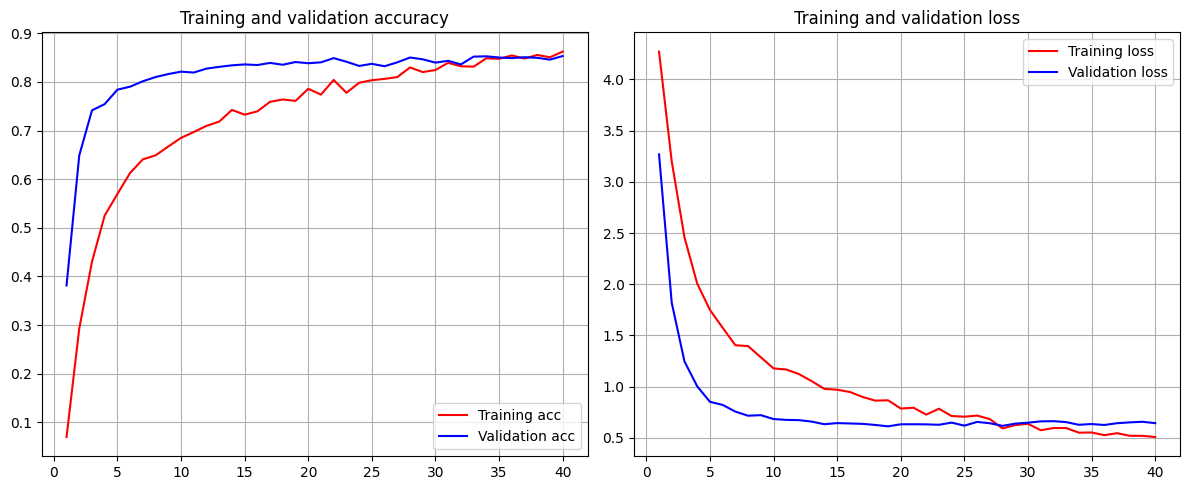

In [43]:
import matplotlib.pyplot as plt
 
## visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
     
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
     
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].grid(True)
    axs[0].legend()
     
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].grid(True)
    axs[1].legend()
     
    plt.tight_layout()
    plt.show()
 
visualize(fine_tune_inception)

<br><br>

## Make Prediction

In [44]:
# save model
model.save('last_model.h5')


1/1 [==============================] - 2s 2s/step
Predicted label: elephant


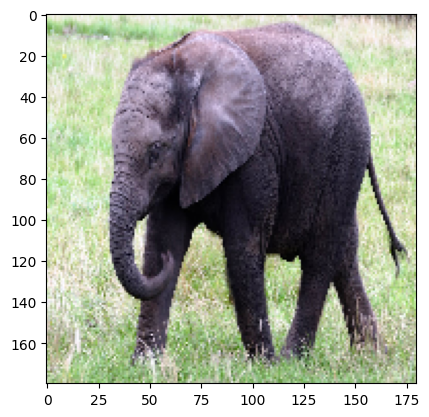

In [45]:
from keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
loaded_model = load_model('last_model.h5')

# Load and preprocess the test image
img_path = 'test-image.jpg'
img = image.load_img(img_path, target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize as in training
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
preds = loaded_model.predict(img_array)
predicted_class_idx = np.argmax(preds, axis=1)[0]

# Load labels from archive\name of the animals.txt
with open('archive\\name of the animals.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

predicted_label = labels[predicted_class_idx]
print(f"Predicted label: {predicted_label}")

plt.imshow(img)

<br><br>